In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import rayleigh
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

SCALE  = 7.35
N      = 10000
N_BINS = 160

# 1 
Generar una muestra aleatoria de $10,000$ puntos de la distribución de $Rayleigh$ utilizando `scale = 7.53`.

In [2]:
def rayleigh_pdf(n_samples, scale=SCALE):
    rx = np.linspace(0, max(rayleigh_data), n_samples)
    return ((rx /SCALE **2) * np.exp(-rx**2 / (2 * SCALE**2)))

# Datos de entrada (features)
rayleigh_data = np.random.rayleigh(scale=SCALE, size=N)
# Datos reales (labels)
rx = np.linspace(0, max(rayleigh_data), N)
ray_pdf = rayleigh_pdf(N) 

rayleigh_data.shape, ray_pdf.shape 

((10000,), (10000,))

# 2
Obtén $160$ puntos del histograma de tu muestra.

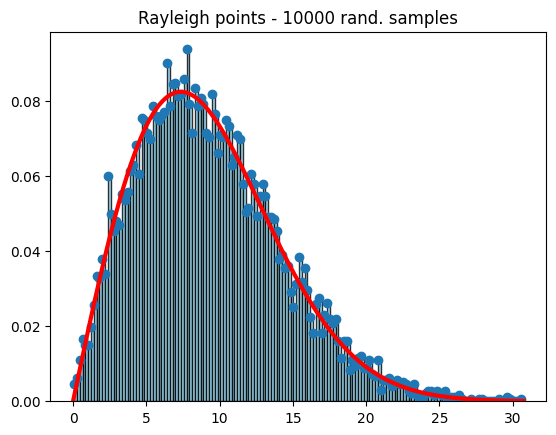

In [3]:
hist, bin_edges = np.histogram(rayleigh_data, bins=N_BINS, density=True)
plt.hist(rayleigh_data, bins=N_BINS, density=True, alpha=0.8, color='skyblue', edgecolor='black')
plt.scatter(bin_edges[:-1],hist)
plt.plot(rx, ray_pdf, 'r', linewidth=3)
plt.title('Rayleigh points - 10000 rand. samples')
plt.show()

# 3
Divide los puntos en conjunto de entrenamiento y prueba (80-20).

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(bin_edges[:-1], hist, test_size=0.2, random_state=0)
#X_train, X_test = train_test_split(rayleigh_data, test_size=0.2, random_state=0)
#Y_train = rayleigh.pdf(X_train, scale=SCALE)
#Y_test  = rayleigh.pdf(X_test, scale=SCALE)
X_train.shape, Y_train.shape, Y_test.shape, Y_test.shape

((128,), (128,), (32,), (32,))

# 4 
Realiza una regresión polinomial del conjunto de entrenamiento probando distintos grados
de polinomio. Calcula el sesgo y varianza para cada grado utilizado (Es posible que
tengas que dividir tu conjunto de entrenamiento en entrenamiento y validación). Imprime
los resultados en un dataframe de pandas: grado del polinomio, sesgo, varianza, $MAE,
MSE, R2$.

In [5]:
def reshape_data(X, y):
    return X.reshape(-1,1), y.reshape(-1,1)

def to_polynomial(X, deg):
    return PolynomialFeatures(degree=deg).fit_transform(X)

def compute_metrics(x_true_pol, y_true, y_hat):
    mae  = mean_absolute_error(y_true, y_hat)
    mse  = mean_squared_error(y_true, y_hat)
    r2   = r2_score(y_true, y_hat)
    bias = np.mean(((x_true_pol) - np.mean(y_hat))**2)
    var  = np.var(y_hat)
    return mae, mse, r2, bias, var

def create_model_df(max_deg, normalized=False):
    df = pd.DataFrame(columns=['grado_modelo', 'mae', 'mse', 'r2_score', 'sesgo', 'varianza'])
    
    model = None
    if(normalized):
        model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    else:
        model = LinearRegression()
    
    for deg in range(1, max_deg + 1):
        x_train, y_train = reshape_data(X_train, Y_train)
        x_test, y_test   = reshape_data(X_test, Y_test)
        x_train_pol = to_polynomial(x_train, deg)
        x_test_pol  = to_polynomial(x_test, deg)
        model.fit(x_train_pol, y_train)
        y_hat   = model.predict(x_test_pol)
        
        mae, mse, r2, bias, var = compute_metrics(x_test_pol, y_test, y_hat)
        
        df.loc[len(df.index)] = [deg, mae, mse, r2, bias, var]
        
    return df

def polynomial_model_linear(max_deg):
    return create_model_df(max_deg)

In [6]:
df = polynomial_model_linear(10)
df

,grado_modelo,mae,mse,r2_score,sesgo,varianza
0,1.0,0.014859,0.000337,0.642493,1.582860e+02,0.000367
1,2.0,0.015263,0.000302,0.679490,5.450282e+04,0.000419
2,3.0,0.006701,0.000062,0.934240,2.472517e+07,0.000935
3,4.0,0.003032,0.000019,0.980293,1.295792e+10,0.000890
4,5.0,0.003513,0.000022,0.977145,7.426134e+12,0.000906
5,6.0,0.003104,0.000019,0.979406,4.522337e+15,0.000935
6,7.0,0.003052,0.000019,0.979867,2.876823e+18,0.000935
7,8.0,0.003081,0.000020,0.979141,1.890753e+21,0.000936
8,9.0,0.003069,0.000019,0.979337,1.274329e+24,0.000935
9,10.0,0.003133,0.000021,0.978153,8.761026e+26,0.000939


# 5
Repite el análisis del punto 4 pero utilizando regularización y validación cruzada.

In [7]:
def polynomial_model_ridgecv(max_deg):
    return create_model_df(max_deg, normalized=True)

In [8]:
df_2 = polynomial_model_ridgecv(10)
df_2

,grado_modelo,mae,mse,r2_score,sesgo,varianza
0,1.0,1.485984e-02,3.372834e-04,6.424690e-01,1.582860e+02,3.667187e-04
1,2.0,1.526227e-02,3.023371e-04,6.795132e-01,5.450282e+04,4.188781e-04
2,3.0,6.650920e-03,6.163588e-05,9.346640e-01,2.472517e+07,9.292707e-04
3,4.0,3.105236e-03,1.899919e-05,9.798603e-01,1.295792e+10,9.171770e-04
4,5.0,8.683018e-01,1.075232e+00,-1.138780e+03,7.426134e+12,1.014293e+00
5,6.0,2.879476e+02,1.193415e+05,-1.265058e+08,4.522335e+15,1.160431e+05
6,7.0,7.927352e+04,9.242446e+09,-9.797284e+12,2.876836e+18,8.862260e+09
7,8.0,4.398003e+07,2.851793e+15,-3.022990e+18,1.890563e+21,2.690926e+15
8,9.0,4.533035e+10,2.965457e+21,-3.143477e+24,1.279730e+24,2.747546e+21
9,10.0,1.502170e+12,3.209432e+24,-3.402099e+27,8.809774e+26,2.912978e+24


# 6
Presenta tu mejor modelo polinomial y argumenta por qué es el mejor.

Consideraremos el mejor modelo basándonos primero en la métrica $R^2$. Dado que, para grados altos los datos comienzan a tener 
una dimensionalidad mayor, las métricas $MAE$ y $MSE$ nos dan valores poco representativos del verdadero error que el modelo presenta, mientras que la métrica elegida presenta información más útil y adecuada para evaluar un modelo polinomial. 

Podremos extraer el mejor modelo de ambos dataframes (modelos no regularizados y regularizados usando `RidgeCV`) buscando el máximo para la métrica `r2_score` y compararemos los mejores obtenidos entre ellos mismos para conocer el mejor. Sin embargo, esto no es suficiente para decidirnos entre estos dos; recordemos que buscamos un balance entre varianza y sesgo, por lo que elegiremos el modelo que tenga ambas métricas lo más balanceadas posible.

In [9]:
best_nonreg = df.iloc[df['r2_score'].argmax()]
best_reg    = df_2.iloc[df_2['r2_score'].argmax()]
best_models = pd.DataFrame([best_nonreg, best_reg], columns=df.columns)
best_models.insert(0, "categoria", ['non_reg', 'reg'])
best_models

,categoria,grado_modelo,mae,mse,r2_score,sesgo,varianza
3,non_reg,4.0,0.003032,0.000019,0.980293,1.295792e+10,0.000890
3,reg,4.0,0.003105,0.000019,0.979860,1.295792e+10,0.000917


Observamos que el modelo regularizado posee una vairanza y un sesgo mucho menor a los presentados por el modelo no regularizado, además de un valor de $R^2$ aceptable. Auque el modelo no regularizado presenta una puntuación perfecta, este posee valores muy altos en cuanto a sesgo y varianza, por lo que decidiremos utilizar el modelo regularizado.

In [10]:
def build_model(model_deg):
    x_train, y_train = reshape_data(X_train, Y_train)
    x_test, y_test   = reshape_data(X_test, Y_test)
    x_train_pol      = to_polynomial(x_train, model_deg)
    x_test_pol       = to_polynomial(x_test, model_deg)
    model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_train_pol, y_train)
    print("mae: {}, mse: {}, r2_score: {}, sesgo: {}, varianza{}"
          .format(*compute_metrics(x_test_pol, y_test, model.predict(x_test_pol))))
    return model

best_deg = int(best_models.iloc[1]['grado_modelo'])
best_model = build_model(best_deg)

mae: 0.0031052364277182457, mse: 1.8999185558070186e-05, r2_score: 0.9798602657657349, sesgo: 12957924594.045824, varianza0.0009171769818433833


# 7
Utiliza la distribución de Rayleigh utilizando el estimador máximo verosímil: `scale = MLE` y compáralo con el modelo polinomial presentado en el punto 6, probando su rendimiento el el conjunto de prueba.

In [18]:
x_test, y_test   = reshape_data(X_test, Y_test)
x_test = to_polynomial(x_test, best_deg)
MLE = np.sqrt((1 / 2*len(x_test)) * np.sum(x_test**2))
#y_mle = np.random.rayleigh(scale=MLE, size=len(y_test))
y_mle = rayleigh_pdf(len(y_test), MLE)
y_hat = best_model.predict(x_test)

mle_mae = mean_absolute_error(y_mle, y_hat)
mle_mse = mean_squared_error(y_mle, y_hat)
mle_r2  = r2_score(y_mle, y_hat)    

print(f"MAE: {mle_mae},\nMSE: {mle_mse},\nR2: {mle_r2}")

MAE: 0.037820302938542355,
MSE: 0.0020808491358759243,
R2: -1.2864644327964947
